In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 64 
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(3, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         XYEncoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="latent")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

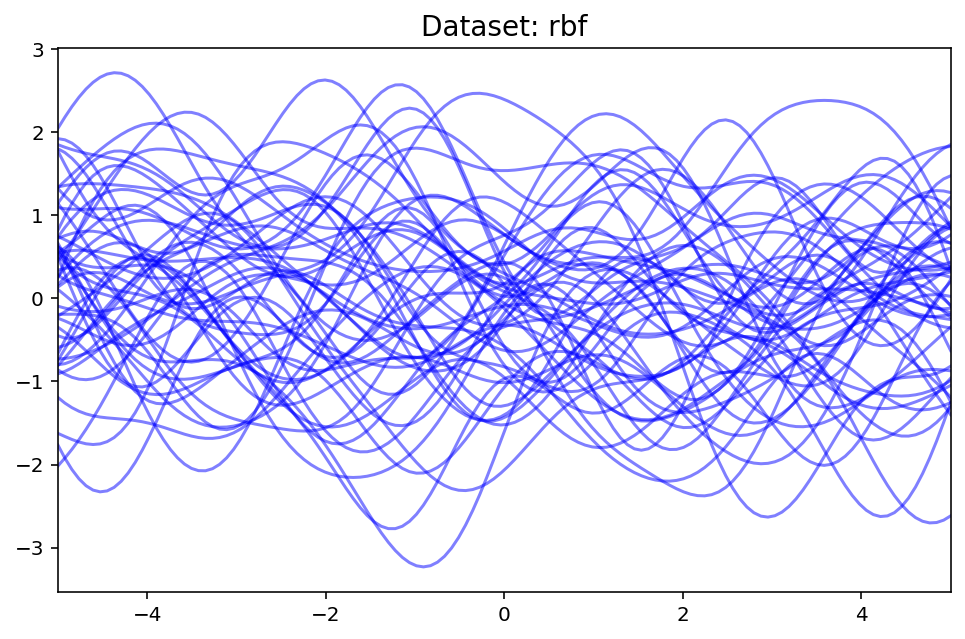

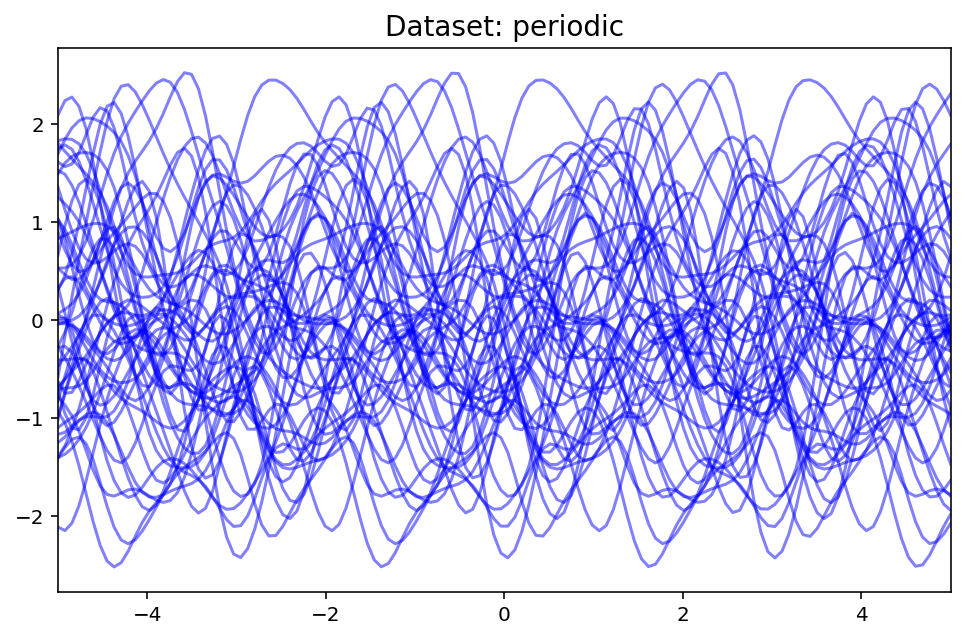

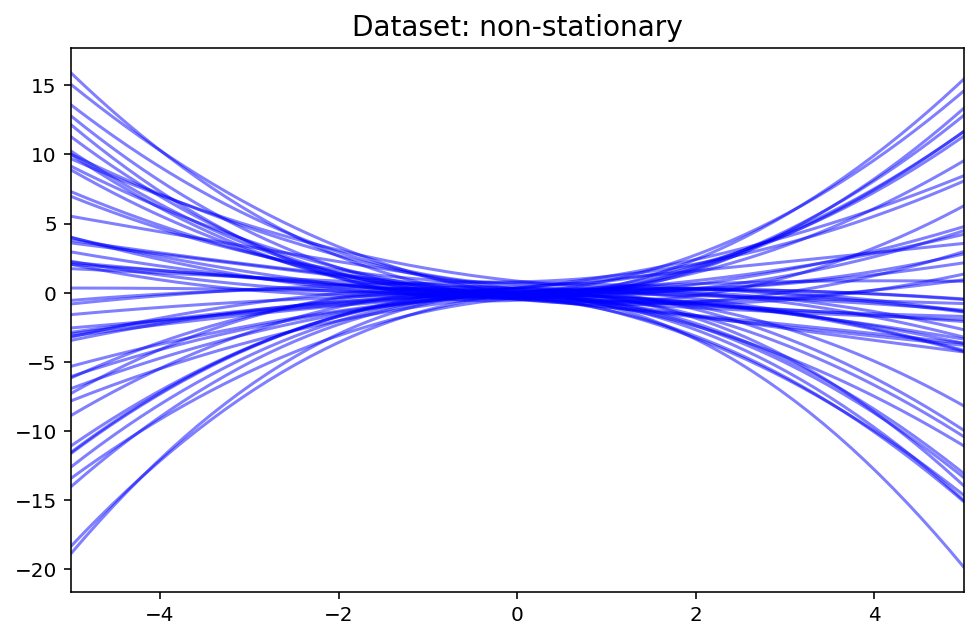

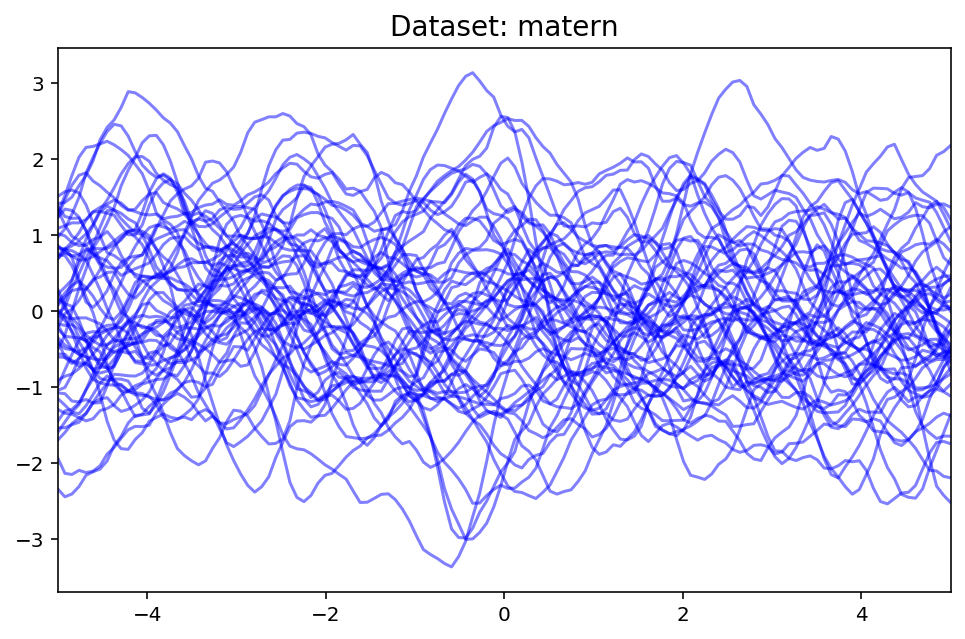

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

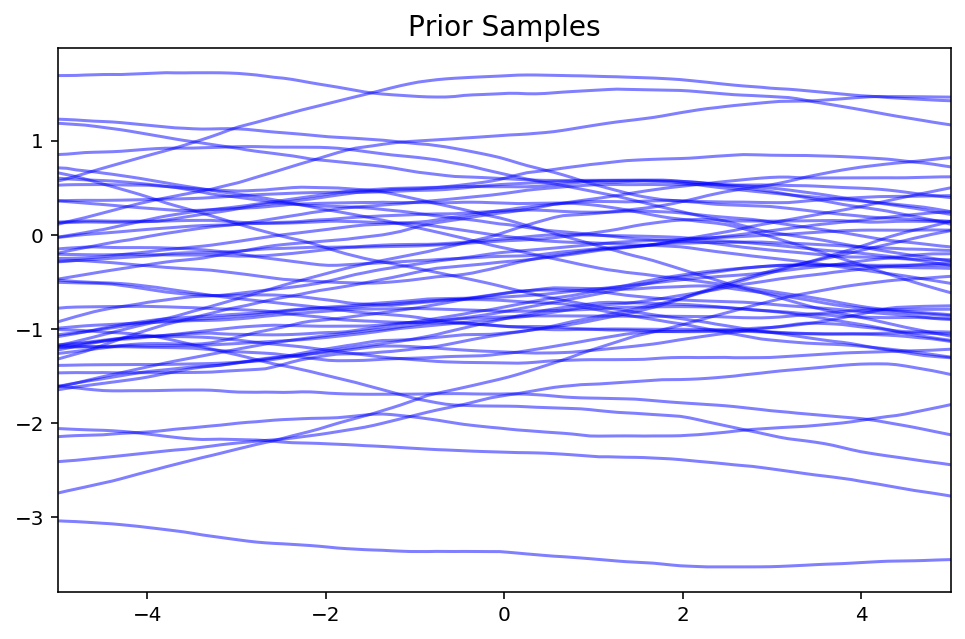

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      157.3014  21.5898


      2      103.5730  18.5040


      3       80.3168  19.2567


      4       60.7688  20.1220


      5       44.1325  20.0819


      6       29.8122  20.3859


      7       14.3745  20.8276


      8        0.9015  20.2199


      9      -12.6858  19.1845


     10      -24.4607  18.0061


     11      -34.4915  20.1295


     12      -41.5190  20.4756


     13      -48.8808  20.0075


     14      -56.3378  19.9138


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      7      129.2089  15.9505


      8      128.4632  17.0092


      9      128.3195  19.8937


     10      128.2678  20.3482


     11      127.9241  20.2538


     12      127.5871  18.5376


     13      127.4814  14.0028


     14      127.4538  16.9767


     15      127.0091  20.8269


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      9      -73.3100  20.1286


     10      -78.7798  20.6275


     11      -84.6759  20.1197


     12      -92.0992  19.8094


     13      -94.5902  20.3983


     14     -100.4514  20.6507


     15     -104.2949  20.5838


     16     -109.0955  20.5751


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     11       79.9320  16.0881


     12       71.4982  12.0447


     13       63.4366  12.0948


     14       56.9322  12.0477


     15       52.7557  12.0506


     16       47.6232  12.0544


     17       42.7204  12.0656


     18       37.8759  12.0708


     19       32.5066  12.0593


     20       29.0980  12.0678


     21       27.3337  12.0797


     22       26.2680  12.8532


     23       21.9707  20.7247


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Trained Prior 
The prior should now encode some information about the shapes of the functions.

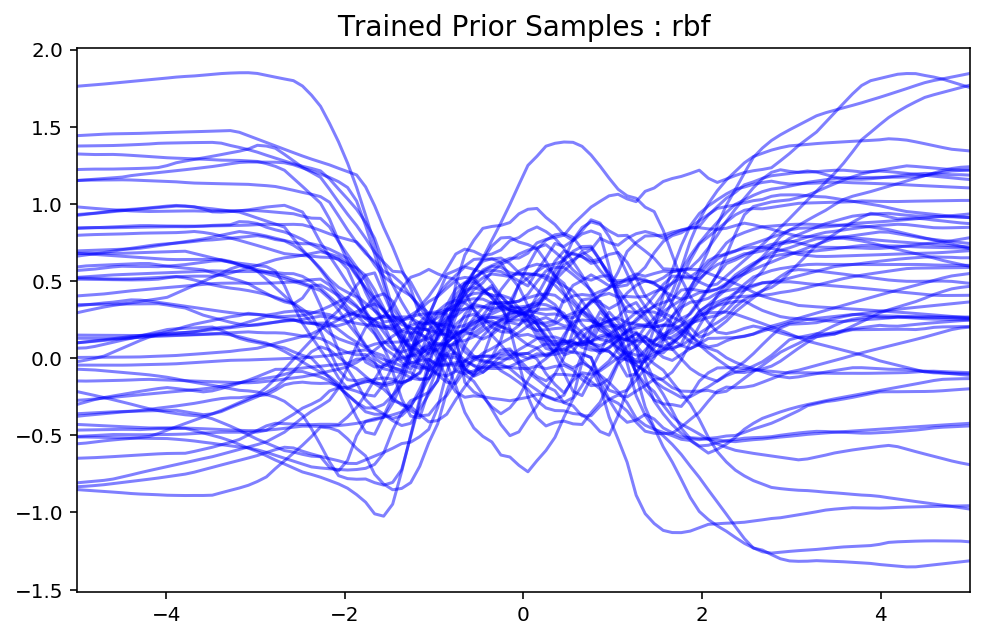

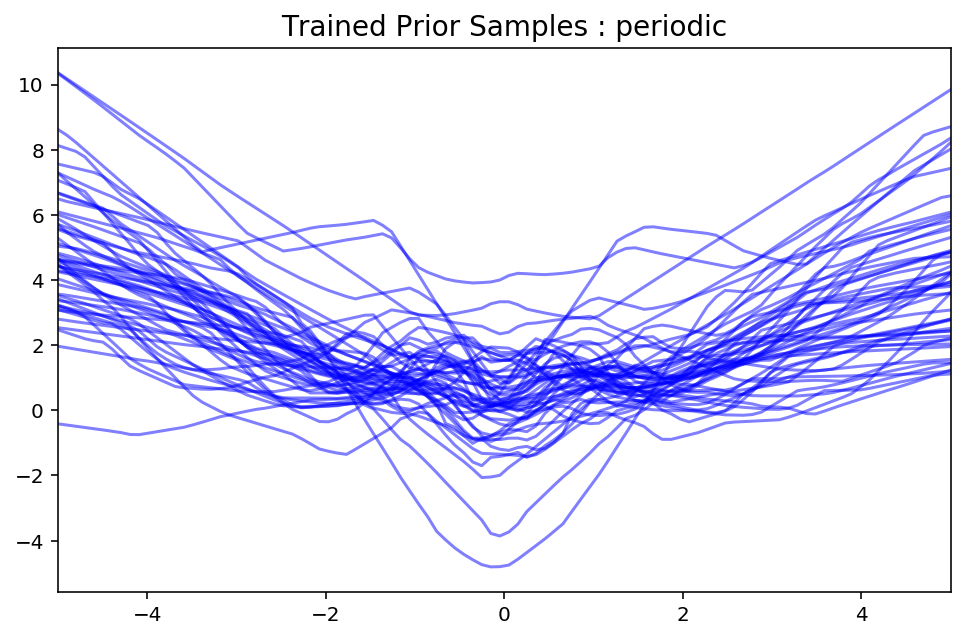

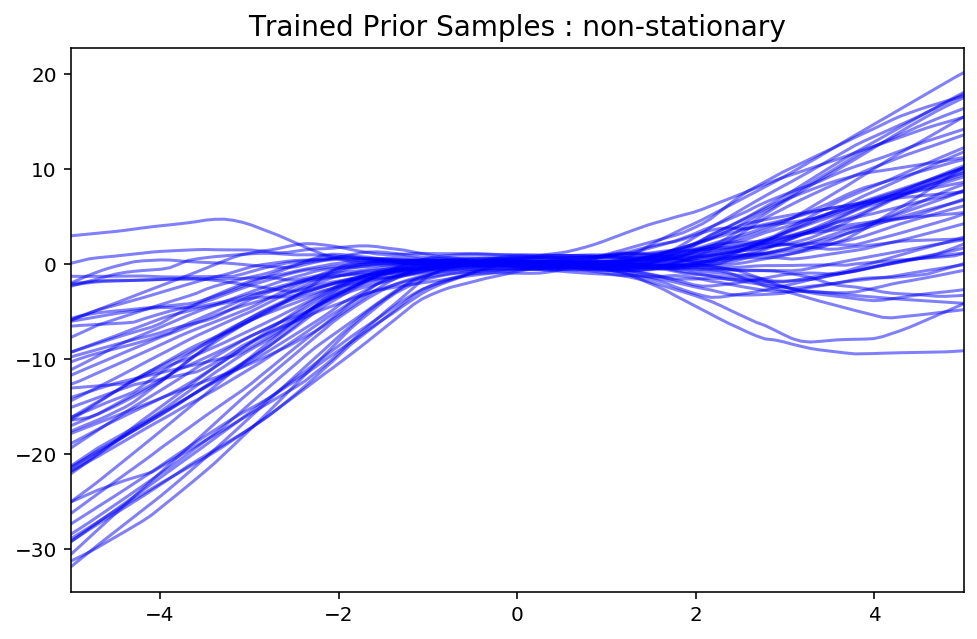

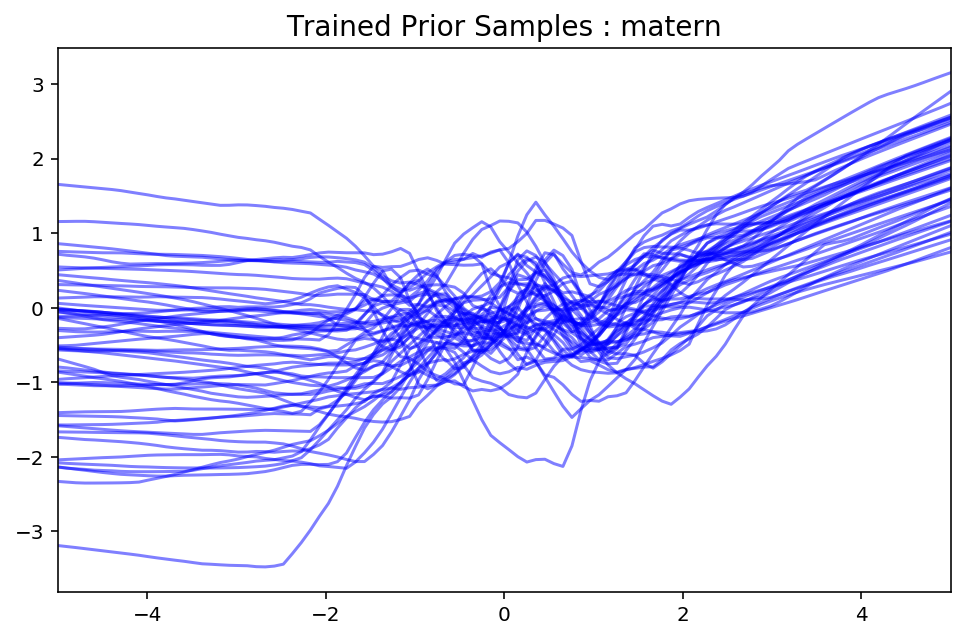

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.10425534
std: 0.23408684
std: 0.13778353
std: 0.29557353


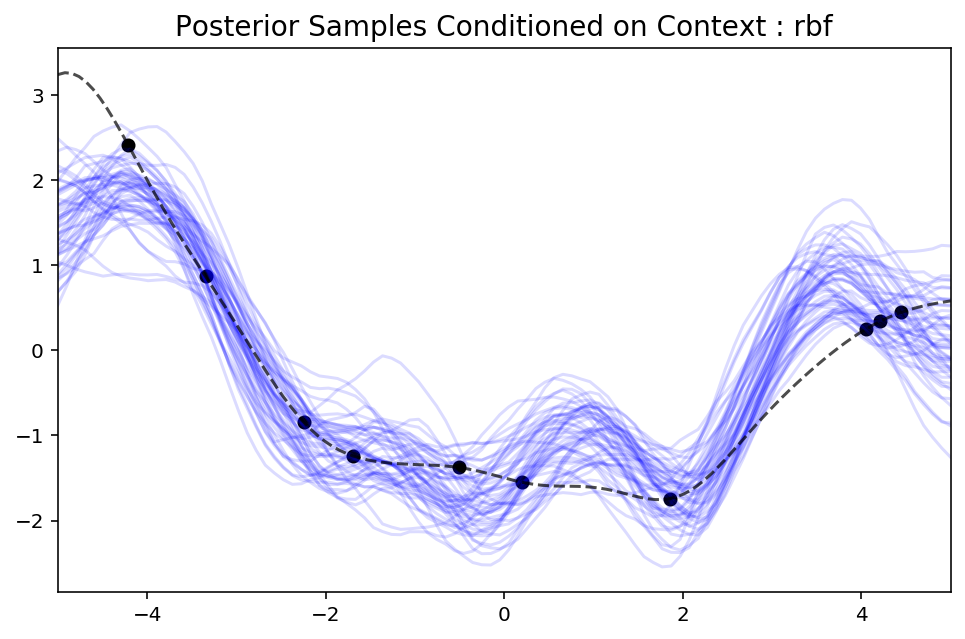

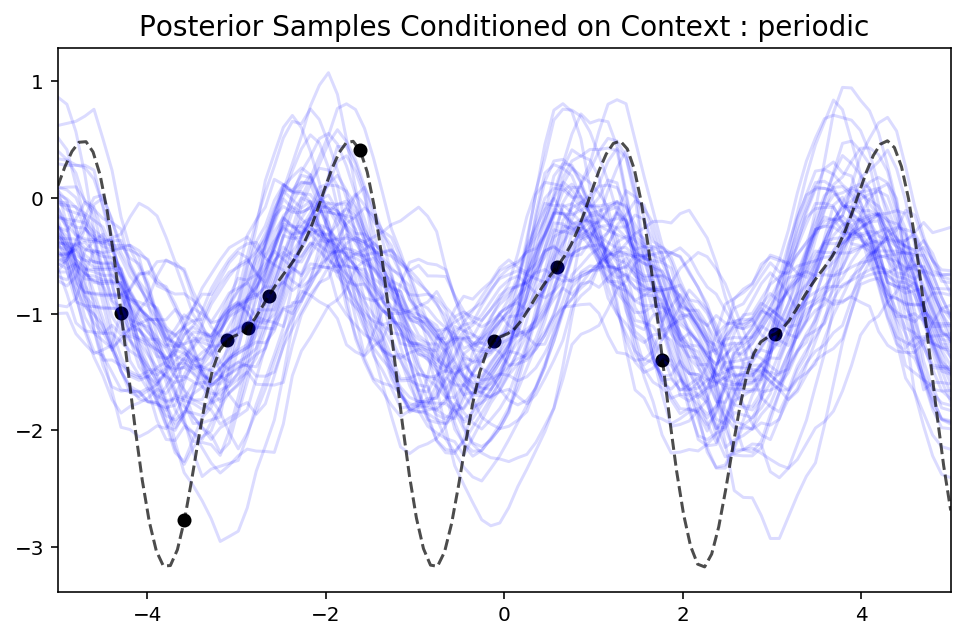

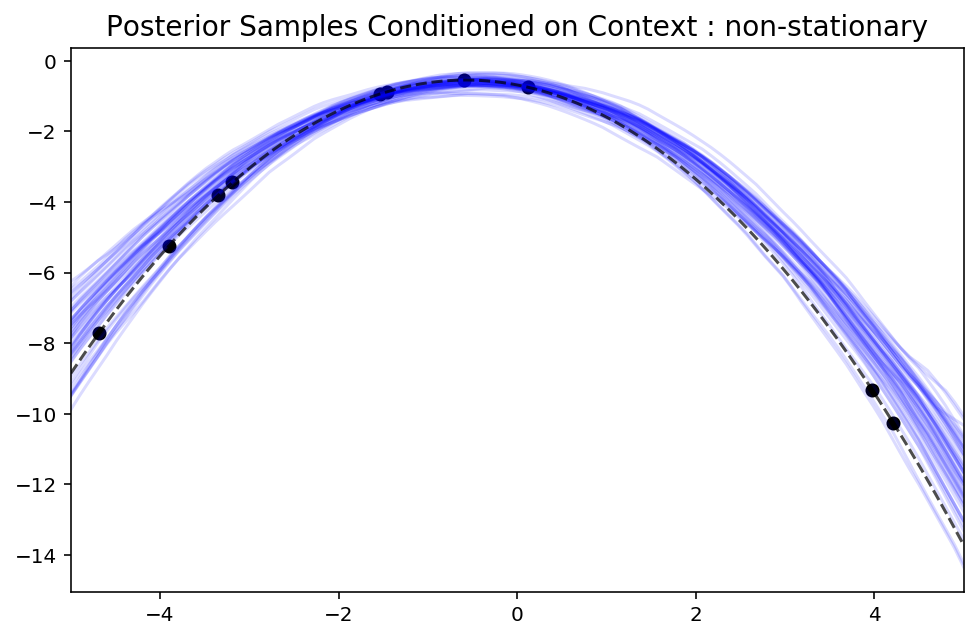

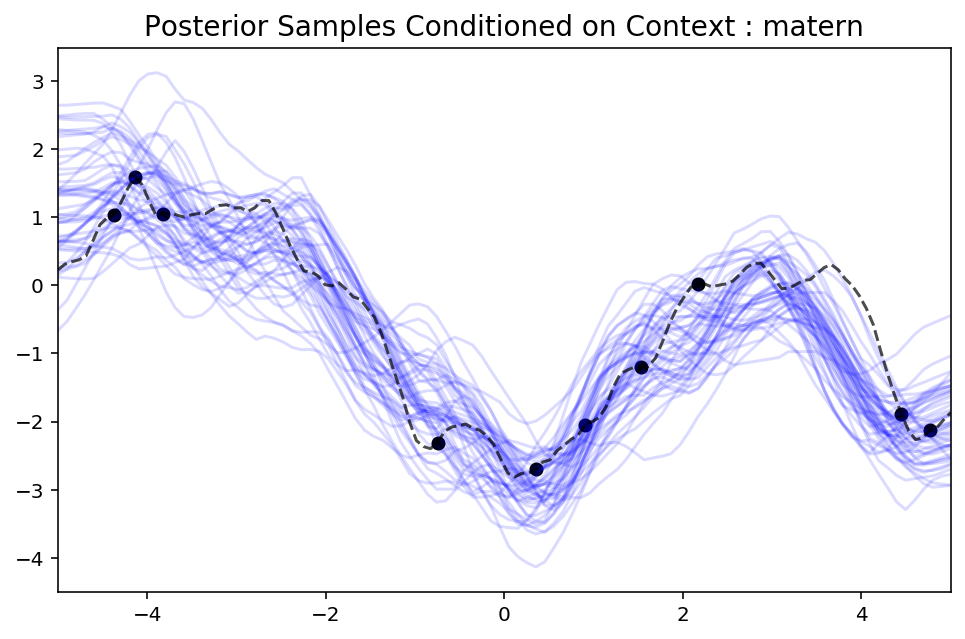

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.10819847
std: 0.16385958
std: 0.10924205
std: 0.22667073


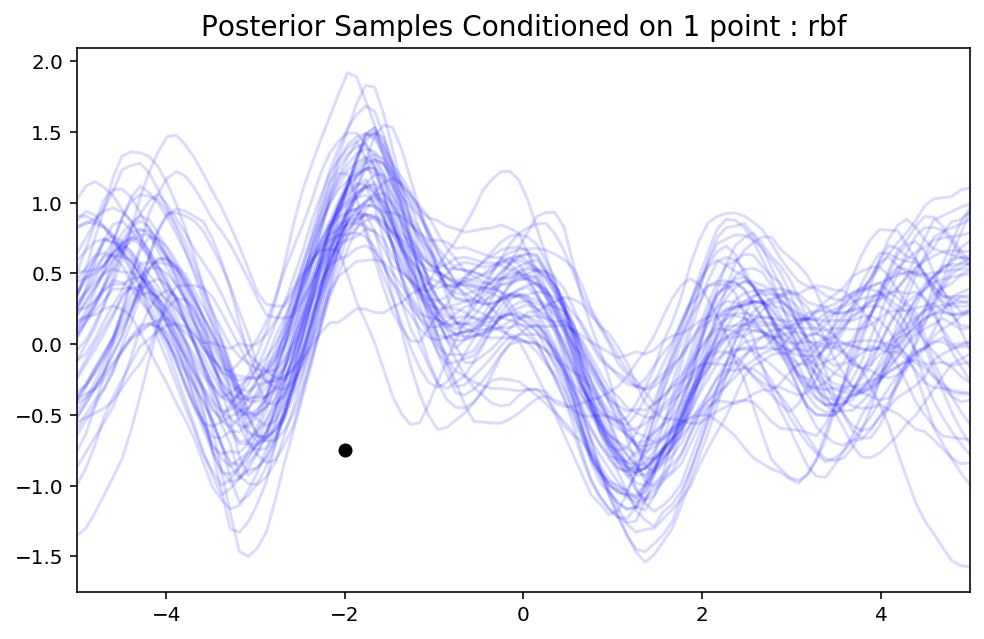

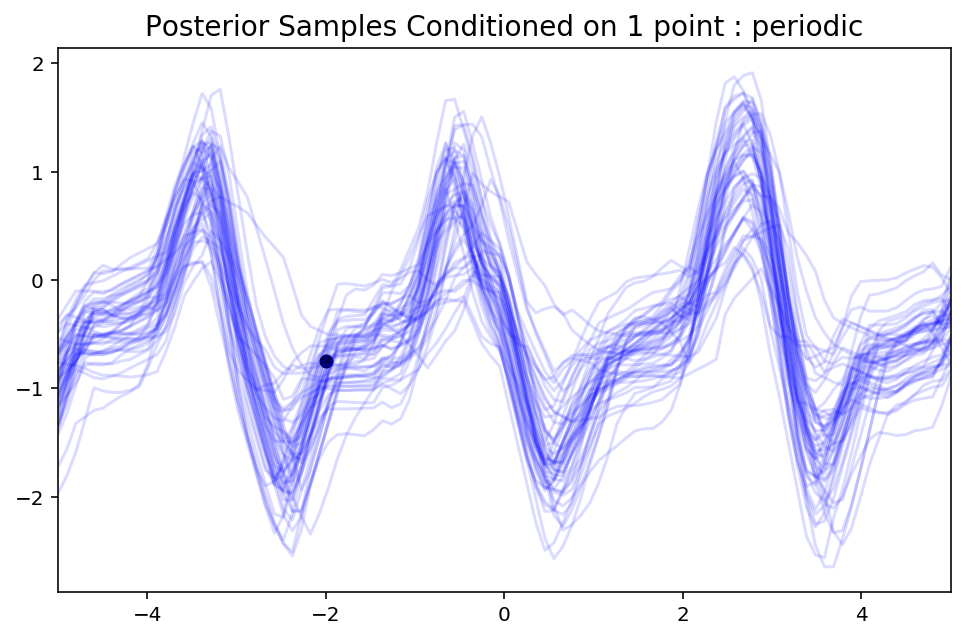

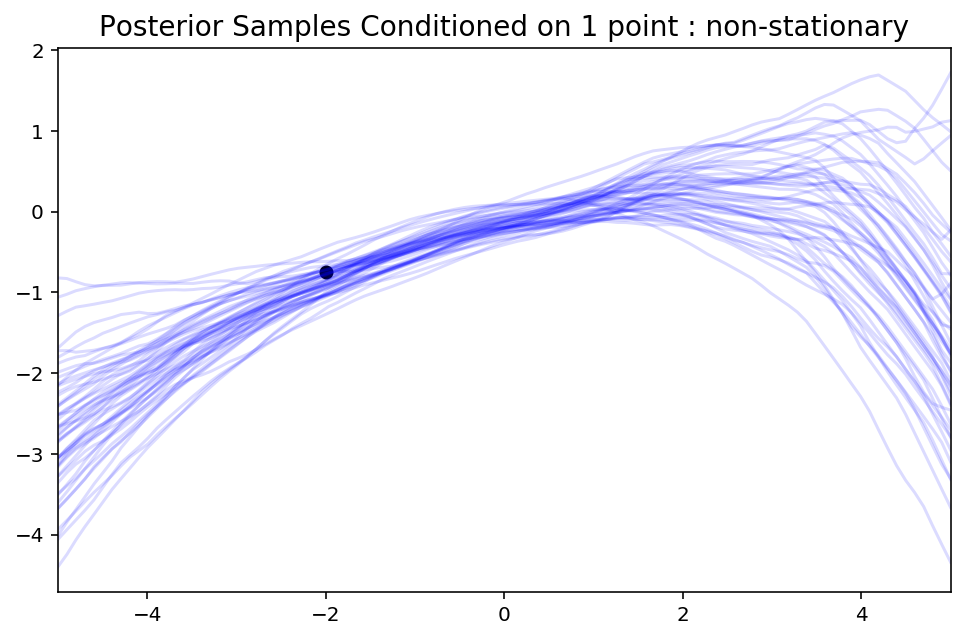

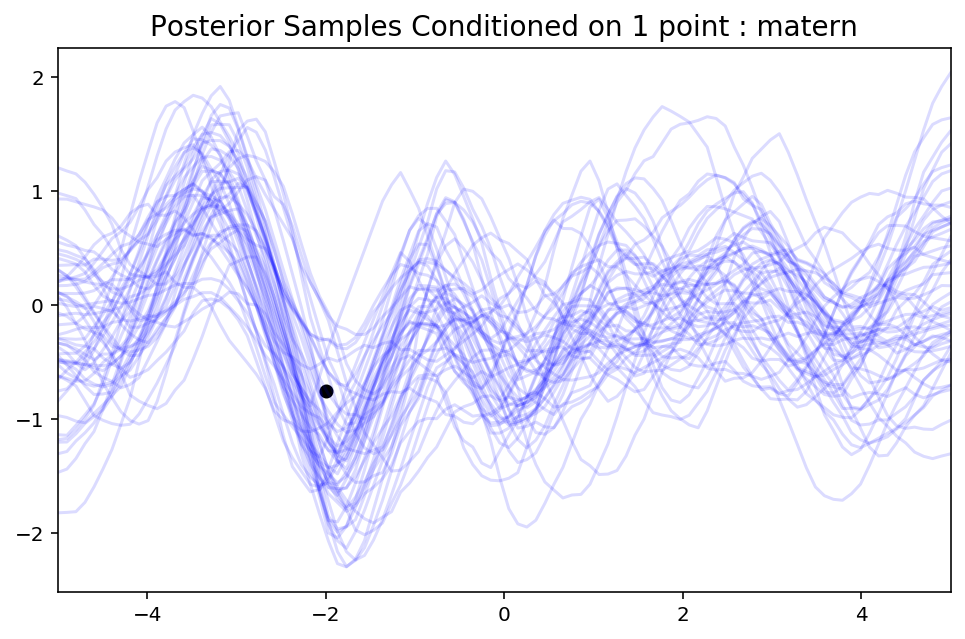

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.24710526
std: 0.16984975
std: 0.10419939
std: 0.25230396


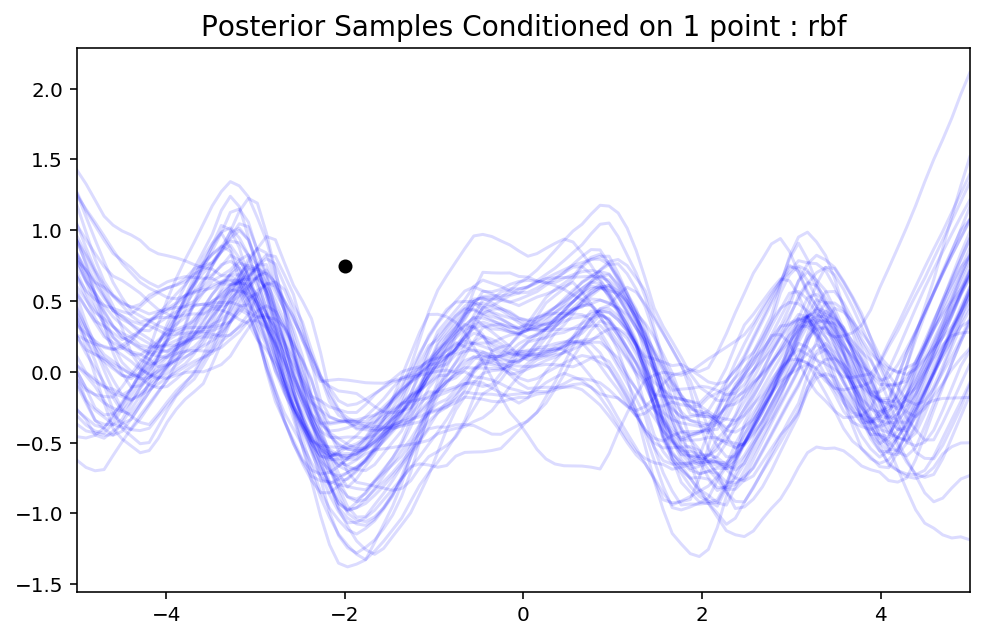

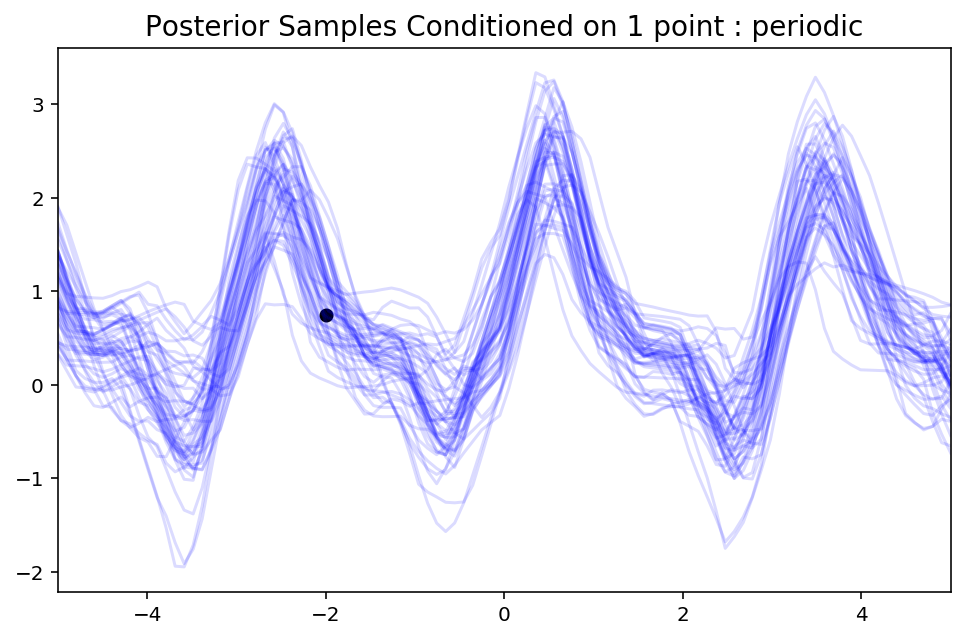

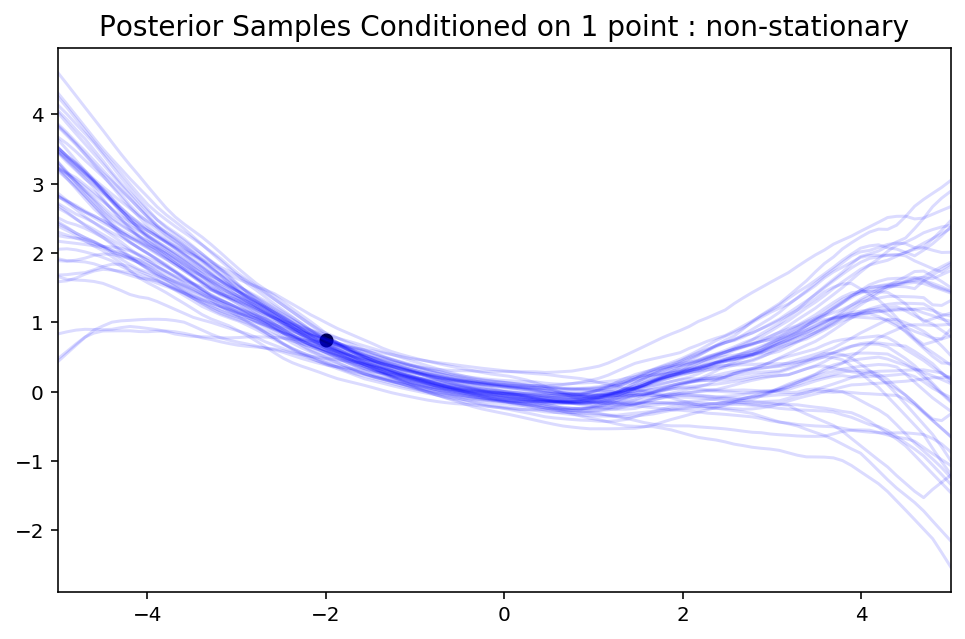

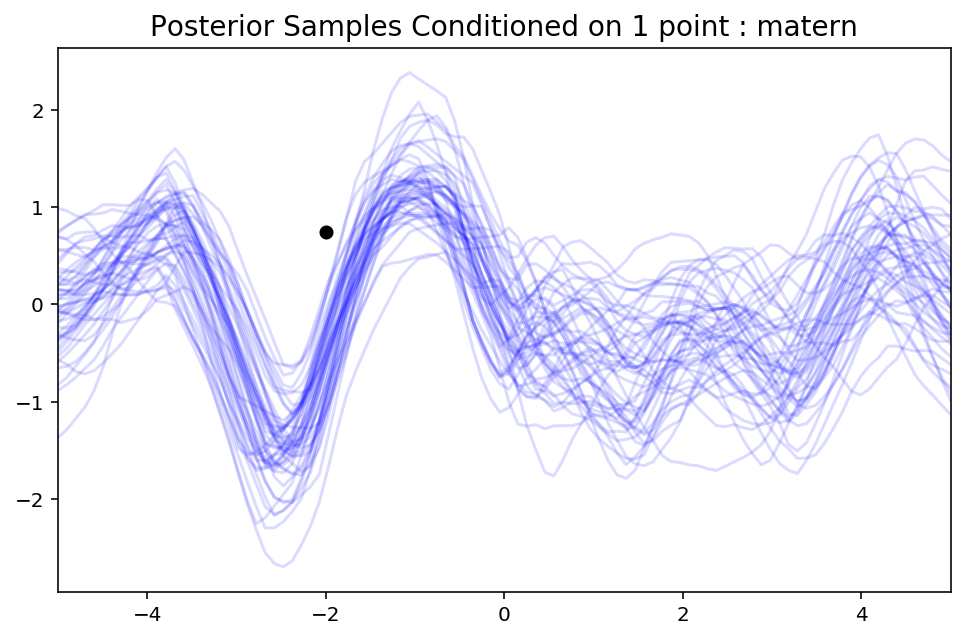

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))